In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import renderstim
import matplotlib.pyplot as plt
import numpy as np

import datajoint as dj
dj.config["enable_python_native_blobs"] = True

from renderstim.schema.main import LatentDataset
from renderstim.schema.scenes import RenderedScenes

from nnfabrik.utility.dj_helpers import Schema

Connecting nikoskar@at-database.ad.bcm.edu:3306


pybullet build time: May 20 2022 19:45:31


In [3]:
def clean_external(schema):
    for store in dj.config['stores']:
        print(f'Deleting store {store}')
        schema.external[store].delete(delete_external_files=True)
        
# schema = Schema("nikoskar_rendered_images")
# clean_external(schema)

# Generating datasets of rendered Stimuli

#### Overview

There are 2 tables that we use to prepare the latent variables needed to generate the scenes:
- 1. The `LatentDataset` table stores the dataset_function, the generator_function, the dataset_config, and the data saving folder
- 2. The `SceneConfig` table is a part table of (1), and stores the configs for all individual scenes

## 1. Insert a Dataset function

In [72]:
s

array([54674, 65655, 72185, 81675, 71553, 53236, 10025, 94954, 93407,
        4292])

In [7]:
# function used to generate a dataset of latent configs
dataset_fn = "renderstim.latents.latent_dataset"

# dataset master config used to generate individual scene configs
dataset_config = dict(
    num_scenes=5100,
    resolution=[256, 144],
    min_num_objects=2,
    max_num_objects=5,
    spawn_region=[[-2.0, -3.0, 1.0], [2.0, 1.0, 2.0]],
    sun_position=[0.0, 0.0, 6.0],
    camera_position=[0.0, -5.5, 6.5],
    camera_look_at=[0.0, 0.0, 0.0],
    camera_focal_length=35.0,
    camera_sensor_width=32.0,
    floor_scale=[20.0, 20.0, 0.01],
    floor_position=[0.0, 0.0, 0.0],
    background_type="mixed"
)

# function used to generate individual scenes
generator_fn = "renderstim.generators.render_scene"
dataset_comment = "mouse v1.0 mixed bg: 5100 scenes"

key = LatentDataset().add_entry(
    dataset_fn=dataset_fn,
    dataset_config=dataset_config,
    generator_fn=generator_fn,
    dataset_comment=dataset_comment
)

# define a key to restrict the table to one entry
key = dict(dataset_hash=key['dataset_hash'])
print(key)

# fill up entries in the part table
LatentDataset().SceneConfig().fill(key)

{'dataset_hash': 'b1912aa71792064f915df148b15c6f71'}
... filling individual scene tables ...


# Delete data from tables if you want

In [8]:
LatentDataset()

dataset_fn name of the dataset loader function,dataset_hash hash of the config object,generator_fn name of the generator function,dataset_config dataset config object,dataset_comment short description,dataset_ts UTZ timestamp at time of insertion
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,=BLOB=,mouse-test v0.0 realistic bg: 100 scenes,2023-02-13 15:51:58
renderstim.latents.latent_dataset,8a807fb3c3534868dd872f622aecd27b,renderstim.generators.render_scene,=BLOB=,mouse v1.0 realistic bg: 5100 scenes,2023-02-13 16:10:46
renderstim.latents.latent_dataset,b1912aa71792064f915df148b15c6f71,renderstim.generators.render_scene,=BLOB=,mouse v1.0 mixed bg: 5100 scenes,2023-02-14 11:42:11


In [9]:
LatentDataset().SceneConfig()

dataset_fn name of the dataset loader function,dataset_hash hash of the config object,generator_fn name of the generator function,scene_hash hash of the config object,scene_config scene config object
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,0216e4617c794938dd7eea7ec1fdc3d3,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,04a608c79d8c454e1c7de55544ac2135,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,04b9c4b3ea708a1aefa6787fd3063e0f,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,0526853c5cd068b1f7a5e36b546f4fbe,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,0cc02eafcd73bff7714feba35862248b,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,0cee05a0e5fcbe0a229ff3971e52f938,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,10aedde489d1661450714020423c2d2e,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,166532456eb2dcb2a4c79a7f48960728,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,18a446c92f5fde1ed0a8b2901ba5f09d,=BLOB=
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,19ff54611b3f4e5132121cd31fcac27e,=BLOB=


In [9]:
# (LatentDataset() & 'dataset_hash="b1912aa71792064f915df148b15c6f71"').delete()

In [39]:
scs = (LatentDataset().SceneConfig() & 'dataset_hash="b1912aa71792064f915df148b15c6f71"').fetch('scene_config')

In [57]:
errors = []

err = [
    1799163640,
    1666391728,
    896071950,
    1412455509,
    553164331,
    861905851,
    1838895271,
    663454199,
    445379293,
    996864751,
    280300542,
    1704141852,
    1225057742,
    1792576729,
    1626511722,
    1451615222,
    1525941285
]

for i, sc in enumerate(scs):
    for e in err:
        if sc['seed'] == e:
            errors.append(dict(seed=e, idx=i))
            
errors

[{'seed': 1799163640, 'idx': 729},
 {'seed': 1666391728, 'idx': 1097},
 {'seed': 896071950, 'idx': 1449},
 {'seed': 1412455509, 'idx': 1589},
 {'seed': 553164331, 'idx': 1650},
 {'seed': 861905851, 'idx': 1763},
 {'seed': 1838895271, 'idx': 1820},
 {'seed': 663454199, 'idx': 1979},
 {'seed': 445379293, 'idx': 2509},
 {'seed': 996864751, 'idx': 2856},
 {'seed': 280300542, 'idx': 3009},
 {'seed': 1704141852, 'idx': 3218},
 {'seed': 1225057742, 'idx': 3442},
 {'seed': 1792576729, 'idx': 3605},
 {'seed': 1626511722, 'idx': 4180},
 {'seed': 1451615222, 'idx': 4467},
 {'seed': 1525941285, 'idx': 5005}]

In [56]:
shs = (RenderedScenes() & 'dataset_hash="b1912aa71792064f915df148b15c6f71"').fetch('scene_hash')
shs = [shs[x['idx']] for x in errors]
shs

['4ddc901d02647d96bd110c9e447805b7',
 '591734172f8dbd5997007a8e773857ed',
 'ea35e609348caab648d90cf2c7f6f475',
 '20a096973bf5c541826740cf570b7aa7',
 '466af3a4b2f82b038f31c9c28afba37c',
 'cb8d8f6f7068555532383ec6a999e016',
 '03030919a0f4b161bd593f08d739fa7d',
 'ad16997557b2763c167c37f5f4b66129',
 '7e5347bfe4bcac408737cf491b22b636',
 '5beb712067a1dcc63ef42e5e51c4cfcd',
 'c76bacc1613812fa2e21cf0c8b4d84f2',
 'e9016c7cba3f85eb82cf2fec7a19e296',
 'b3b9b5b7c296af4c16cc37822b43ecf7',
 'bbcdab20dd1a7757303e81a909c97f63',
 '42a6ceb6057abb97c360a1009d2c995c',
 '2f55785096abb94580df6fb729bcc170',
 'e79211f35ac160979d544bc44135a095']

In [65]:
err_scenes = []

for sh in shs:
    sce = (RenderedScenes() & dict(scene_hash=sh)).fetch1('scene')
    err_scenes.append(sce)

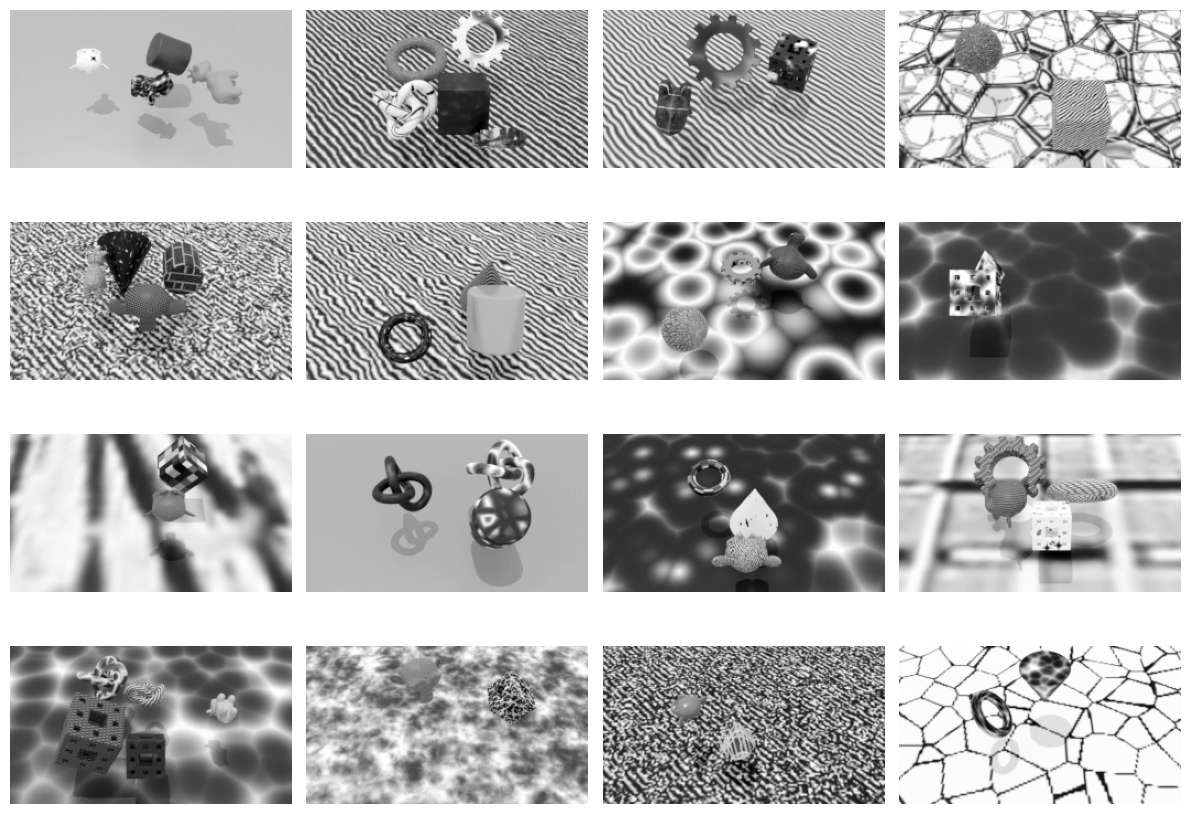

In [69]:
fig, axs = plt.subplots(4, 4, figsize=(12, 9), dpi=100)
axs = axs.ravel()

for i, s in enumerate(err_scenes[:-1]):
    axs[i].imshow(s, cmap="gray")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

# 3. Render the Images

In [38]:
RenderedScenes()

dataset_fn name of the dataset loader function,dataset_hash hash of the config object,generator_fn name of the generator function,scene_hash hash of the config object,scene,segmentation,object_coordinates,normals,depth,metadata dict containing metadata about the scene,rendering_ts UTZ timestamp at time of insertion
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,0216e4617c794938dd7eea7ec1fdc3d3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:39
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,04a608c79d8c454e1c7de55544ac2135,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:39
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,04b9c4b3ea708a1aefa6787fd3063e0f,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:39
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,0526853c5cd068b1f7a5e36b546f4fbe,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:45
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,0cc02eafcd73bff7714feba35862248b,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:44
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,0cee05a0e5fcbe0a229ff3971e52f938,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:45
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,10aedde489d1661450714020423c2d2e,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:48
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,166532456eb2dcb2a4c79a7f48960728,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:53
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,18a446c92f5fde1ed0a8b2901ba5f09d,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:52
renderstim.latents.latent_dataset,82eb3529f6eeac4e1832a7f092f313d3,renderstim.generators.render_scene,19ff54611b3f4e5132121cd31fcac27e,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2023-02-13 16:02:54


In [ ]:
shs = (RenderedScenes() & 'dataset_hash="8a807fb3c3534868dd872f622aecd27b"').fetch('scene_hash')
1799163640

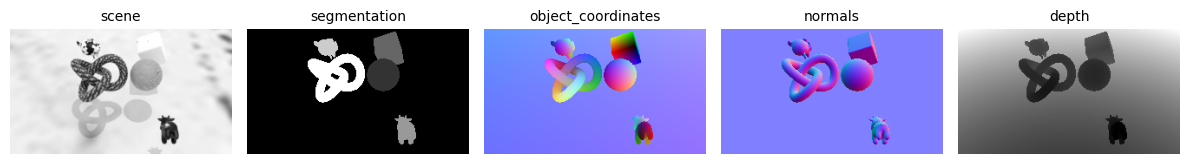

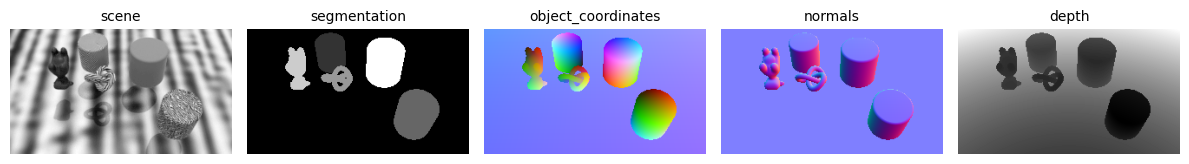

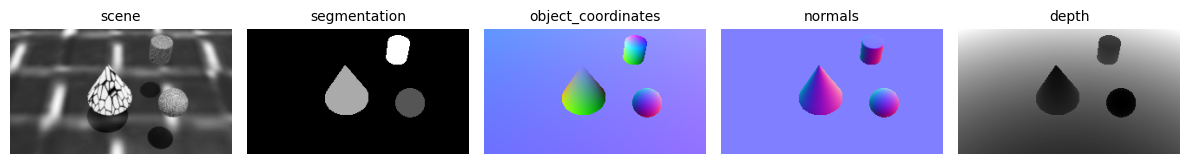

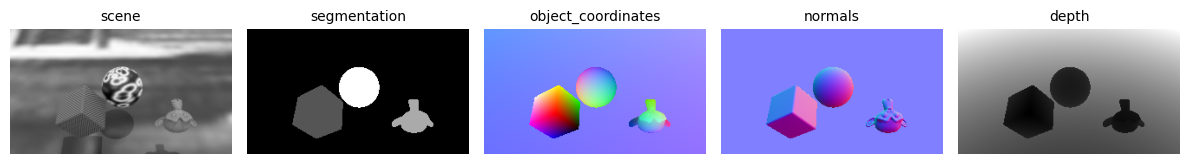

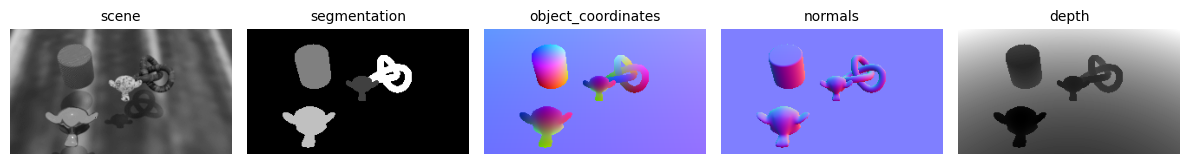

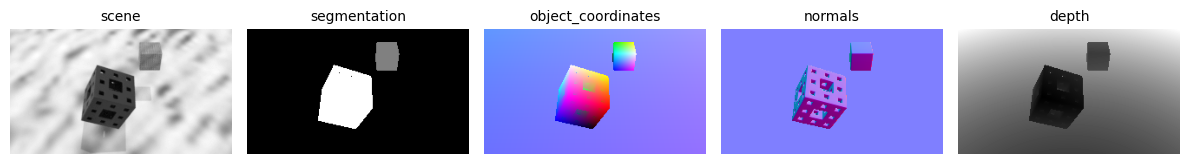

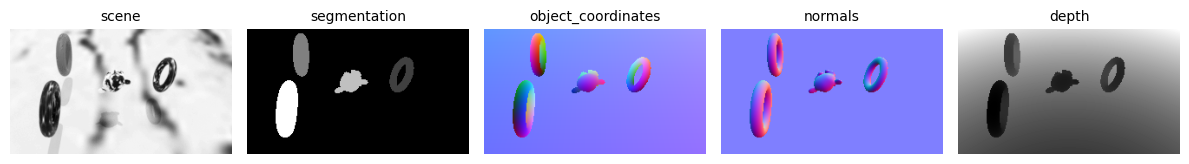

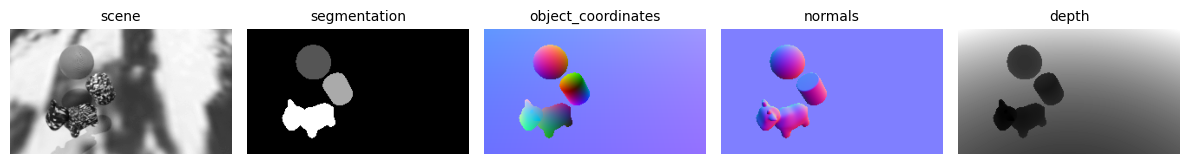

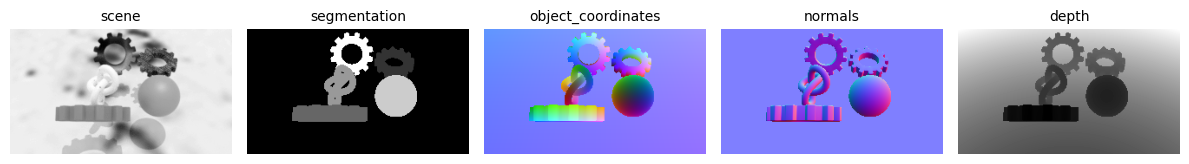

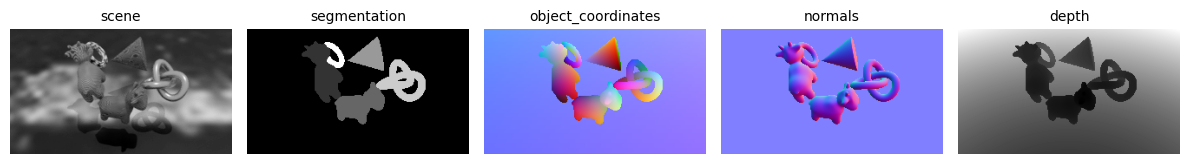

In [25]:
shs = (RenderedScenes() & 'dataset_hash="8a807fb3c3534868dd872f622aecd27b"').fetch('scene_hash')[:10]

outs = [
    "scene", 
    "segmentation", 
    "object_coordinates", 
    "normals", 
    "depth", 
    "metadata"
]

for sh in shs:
    fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=100)
    axs = axs.ravel()

    img_outs = [(RenderedScenes() & dict(scene_hash=sh)).fetch1(out) for out in outs]

    for i, ax in enumerate(axs):
        ax.imshow(img_outs[i], cmap="gray")
        ax.set_title(outs[i], fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()